# Toy example - Fit a mixture of two Gaussians using GeoPVI

In this tutorial, we demonstrate how to use the GeoPVI package to perform a simple density estimation problem where the unknown probability distribution is a mixture of two Gaussians

We will consider **normalising flows** and **boosting variational inference** (BVI). ADVI and PSVI essentially assume a Gaussian variational distribution thus are not suitable to fit a GMM.

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from scipy.stats import norm
import geopvi

In [2]:
torch.set_default_dtype(torch.float64)

## Define the target probability distribution

In the following code block, we define the target probability distribution as a mixture of two Gaussians using torch.distributions - which will be inferred later in the tutorial using **_BVI_** and **_normalising flows_** provided in GeoPVI

In [3]:
mix = torch.distributions.Categorical(torch.tensor([0.5, 0.5]))
comp = torch.distributions.Normal(torch.tensor([-1, 1]), torch.tensor([0.4,0.6]))
gmm = torch.distributions.MixtureSameFamily(mix, comp)

In [4]:
def mog(x):
    tmp = gmm.log_prob(x)
    return tmp

In [5]:
x = np.arange(-10, 10, 0.001)

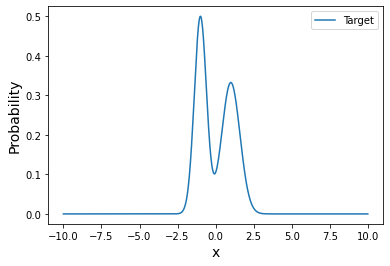

In [6]:
plt.figure()
plt.plot(x, np.exp(mog(torch.from_numpy(x[:,None]))), label = 'Target')
plt.xlabel('x', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
plt.legend()
plt.show()

## Inference using BVI

In [7]:
from geopvi.boostingvi.bvi import BoostingGaussian
from geopvi.boostingvi.component import GaussianComponent

### 1. Define a Gaussian component distribution

To solve this inference problem using BVI, we will need a component distribution which is a Gaussian distribution in this case

We define a unconstrained Gaussian distribution as the component distribution, and a **Normal** base distribution. 

In GeoPVI, the Gaussian component distribution is defined by applying a Linear transform:
- $\mathbf{z} = \mu + \mathbf{L}\mathbf{x}$

where $\mathbf{x}$ is distributed according to either a standard normal distribution N(0, I) or a Uniform distribution U(0, 1) - depending on the **base** distribution.

In [8]:
component = GaussianComponent(dim = 1, perturb = 2, base = 'Normal', constrained = False)

### 2. Define a boosting Gaussian model as the variational distribution

Then, we can define a bvi object by calling the _BoosingGaussian_ provided by GeoPVI, which requires:
- a componentDistribution (the Gaussian component defined above)
- a function to evaluate the log-probability value of the target distribution (**mog** in this case), which takes in model samples (torch.tensor) and output log-prob values
- **lmb** is a function to calculate the regularisation coefficient used in BVI (see equation 10 in [Zhao & Curtis 2024 - JGR: solid Earth](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023JB027789))
- the weight for each new component distribution is initialised in an decreasing order

In [42]:
bvi = BoostingGaussian(componentDistribution = component, log_posterior = mog, lmb=lambda x: 1./(x+1)**0.5, weight_init='decreasing')

In this test, we boost 10 Gaussian components. Each component is optimised by 5000 iterations and 5 samples per iteration for Monte Carlo integration.

In [43]:
n_comp = 10

In [44]:
results = bvi.update(ncomponent = n_comp, n_iter = 5000, nsample = 5, verbose = True, n_out = 1)

----------------------------------------
Optimizing component 1... 
Iteration:     0, 	Loss: 0.758379
The elapsed time is:  0.002843141555786133
Iteration:  5000, 	Loss: 0.326538
The elapsed time is:  3.0158400535583496
Optimization of component 1 complete

----------------------------------------
Optimizing component 2... 
Iteration:     0, 	Loss: 0.006414
The elapsed time is:  0.0014026165008544922
Iteration:  5000, 	Loss: -0.959393
The elapsed time is:  4.529672622680664
Optimization of component 2 complete

----------------------------------------
Optimizing component 3... 
Iteration:     0, 	Loss: 0.063059
The elapsed time is:  0.0013077259063720703
Iteration:  5000, 	Loss: -0.097349
The elapsed time is:  4.5160768032073975
Optimization of component 3 complete

----------------------------------------
Optimizing component 4... 
Iteration:     0, 	Loss: 31.090773
The elapsed time is:  0.0014753341674804688
Iteration:  5000, 	Loss: -0.432936
The elapsed time is:  4.6806700229644775


### 3. Retrive the results and plot

Once training is finsihed, we can retrive the inversion results, which is a Python dictionary containing weights, mus and covariances of each Gaussian component.

We can use these information to calculate the otained GMM variational distribution

In [45]:
weight = results['weights'].numpy()
mus = results['mus'].numpy()
sigmas = results['stds'].numpy()

In [46]:
marginal = np.zeros(x.shape[0])
for i in range(n_comp):
    marginal += norm.pdf(x, loc = mus[i,0], scale = sigmas[i, 0]) * weight[i]

Alternatively, GeoPVI provides a **sample** function, so that you can directly draw samples from the boostingGaussian distribution.

In [47]:
samples = bvi.sample(nsamples = 5000)

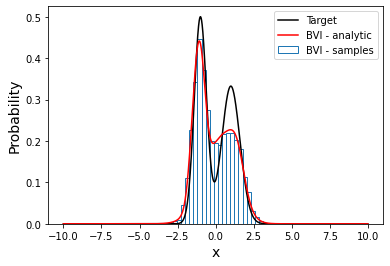

In [48]:
plt.figure()
plt.plot(x, np.exp(mog(torch.from_numpy(x[:,None]))), label = 'Target', color = 'black')
plt.xlabel('x', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
sns.histplot(samples, bins = 30, stat="density", linewidth=1, fill=False, label = 'BVI - samples')
plt.plot(x, marginal, label = 'BVI - analytic', color = 'red')
plt.legend()
plt.show()

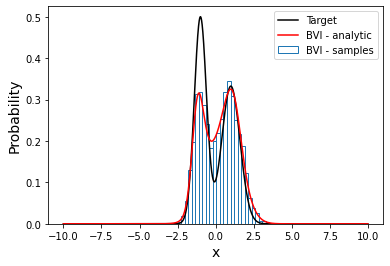

In [29]:
plt.figure()
plt.plot(x, np.exp(mog(torch.from_numpy(x[:,None]))), label = 'Target', color = 'black')
plt.xlabel('x', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
sns.histplot(samples, bins = 30, stat="density", linewidth=1, fill=False, label = 'BVI - samples')
plt.plot(x, marginal, label = 'BVI - analytic', color = 'red')
plt.legend()
plt.show()

## Inference using normalising flows

In [16]:
from geopvi.nfvi.flows import Planar
from geopvi.nfvi.models import FlowsBasedDistribution, VariationalInversion

### 1. Define a flows-based distribution

Specifically in this example, we will use Planar flows ([Rezende & Mohaned, 2015](https://arxiv.org/abs/1505.05770)).

We define a flows-based model as a combination of 5 planar flows, which is then used to define a variational distribution that is an FlowsBasedDistribution object provided by GeoPVI.

In [36]:
flows = []
for i in range(5):
    flows += [Planar(dim = 1)]

The base distribution is a Standard normal distribution N(0, I).

ALternatively, you can also use a Uniform base distribution by setting **_base = 'Uniform'_**.

In [37]:
variational_pdf = FlowsBasedDistribution(flows = flows, base = 'Normal')

### 2. Perform variational inference - in this example we use a wrapper provided by GeoPVI.

GeoPVI provides a wrapper to peroform variational inversion $-$ **VariationalInversion** clase, which encapsulate variational optimisation process in VariationalInversion.update() function.

It takes the defined **FlowsBasedDistribution** and a function estimating the log-probability value of the target function as input.

In [38]:
nfvi = VariationalInversion(variationalDistribution = variational_pdf, log_posterior = mog)

Variational inference will be performed by calling VariationalInversion.update() function, which will return the **negative ELBO** (loss function in this case) for each iteration.

In [39]:
loss = nfvi.update(n_iter = 5000, nsample = 5, verbose = True, n_out = 5)

----------------------------------------

Iteration:     0,	Loss:       3.90
The elapsed time is: 0.01 s
Iteration:  1000,	Loss:      -0.37
The elapsed time is: 2.81 s
Iteration:  2000,	Loss:      -0.34
The elapsed time is: 5.38 s
Iteration:  3000,	Loss:      -0.14
The elapsed time is: 7.98 s
Iteration:  4000,	Loss:       0.11
The elapsed time is: 10.66 s
Iteration:  5000,	Loss:       0.15
The elapsed time is: 13.21 s
----------------------------------------

Finish training!


### 3. Retrive the results and plot

FlowsBasedModel provide a **sample()** function to get samples from the obtained flows-based variational distribution.

In [40]:
samples_nf = variational_pdf.sample(nsamples = 5000).data.numpy()

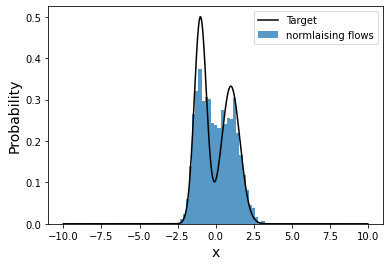

In [41]:
plt.figure()
plt.plot(x, np.exp(mog(torch.from_numpy(x[:,None]))), label = 'Target', color = 'black')
sns.histplot(samples_nf, bins = 30, stat="density", linewidth=0, fill=True, label = 'normlaising flows')
plt.xlabel('x', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
plt.legend()
plt.show()